In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

In [38]:
import pandas as pd

from clustergrammer2 import net

import ipywidgets as widgets
import numpy as np
from bqplot import pyplot as plt
import bqplot
from ipywidgets import HBox

from copy import deepcopy
from glob import glob
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import Voronoi

import warnings
# warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

In [36]:
display(Markdown('# Visum-Clustergrammer2'))

# Visum-Clustergrammer2

In [4]:
# Read Metadata

df_meta = pd.read_csv('data/processed/df_meta_v2.csv', index_col=0)

In [5]:
net.viz = net.load_json_to_dict('data/processed/pre-calc-viz.json')

In [6]:
ini_cat_colors = net.viz['cat_colors']['col']['cat-0']
cat_colors = {}
for inst_key in ini_cat_colors:
    cat_colors[inst_key.split(': ')[1]] = ini_cat_colors[inst_key]

In [7]:
df_meta['plot-x'] = df_meta['pos-x'].apply(lambda x: x/2 - 700)
df_meta['plot-y'] = df_meta['pos-y'].apply(lambda x: x/2 )

In [8]:
df_gex = pd.read_csv('data/processed/gex-z.csv', index_col=0)

In [9]:
dot_names = list(map(lambda x,y: str(x) + '-' + str(y), df_meta['Cell Type'].tolist(), df_meta.index.tolist()) )

In [10]:
def scatter_observe(scatter, hover_data):
    scatter.colors = cell_type_colors
    inst_cat = hover_data['data']['name'].split('-')[0]
    
    list_opacities = []

    for inst_label in df_meta.index.tolist():
        inst_opacity = 0.15
        if df_meta.loc[inst_label, 'Cell Type'] == inst_cat:
            inst_opacity = 1
        list_opacities.append(inst_opacity)        

    # patch.opacities = list_opacities
    scatter.default_opacities = list_opacities    

In [11]:
x_dim = 2000
y_dim = 2000

fig = plt.figure(animation_duration=2000)

# will be re-used to reset cell type colors
cell_type_colors = [ cat_colors[df_meta.loc[x, 'Cell Type']] for x in df_gex.columns.tolist()]

def_tt = bqplot.Tooltip(fields=['name'], formats=[''])

scatter = plt.scatter(df_meta['plot-x'], 
                      df_meta['plot-y'],
                      display_names=False, 
                      default_size=20, 
                      tooltip=def_tt,
                      names=dot_names,
                      colors=cell_type_colors)



scatter.default_size = 105

top_margin = 200
inst_width = 800
inst_height = 1000
fig.layout.min_height = str(inst_height) + 'px'
fig.layout.min_width  = str(inst_width) + 'px'

plt.xlim(0, 2.0*x_dim)
plt.ylim(0, 2.0*y_dim)
fig.title = 'Visium Tissue'
fig.fig_margin = {'top': top_margin, 'bottom': 5, 'left': 5, 'right': 5}


In [12]:
scatter.on_hover(callback=scatter_observe)

In [13]:
default_opacity = 1

In [14]:
def cat_highlight(inst_value):
    
    scatter.colors = cell_type_colors  
    cols = df_gex.columns.tolist()

    if inst_value == 'reset_cats':
        list_opacities = [default_opacity for x in cols]
        scatter.default_opacities = list_opacities
        
    else:
        
        inst_cat_title = inst_value.split(': ')[0]
        inst_cat = inst_value.split(': ')[1]

        list_opacities = []

        for inst_label in cols:
            inst_opacity = 0.15
            if df_meta.loc[inst_label, inst_cat_title] == inst_cat:
                inst_opacity = 1
            list_opacities.append(inst_opacity)        

         
    scatter.default_opacities = list_opacities


In [15]:
def on_value_change(change):
    
    if change['new'] == 'null':
        
        # category highlight
        cat_highlight('reset_cats')
        fig.title = 'Visium Tissue'
        
    else: 
        
        # mousing over category
        if 'cat-' in change['new']:
            inst_cat = change['new'].split(' -> ')[1]
            
            # print('on_value_change', inst_cat)
            cat_highlight(inst_cat)       
            
            fig.title = 'Visium Tissue'
            
        # mousing over marker
        elif 'row-label' in change['new']:
            
            inst_marker = change['new'].split(' -> ')[1]
            ser_opacity = df_gex.loc[inst_marker]
            ser_opacity = ser_opacity / float(np.abs(ser_opacity.max()))
            
            fig.title = 'Visium Tissue: ' + inst_marker
            
            # loop up opacities
            list_opacities = []
            rows = ser_opacity.index.tolist()
            
            list_marker_colors = []
            
            for inst_name in df_gex.columns.tolist():
                
                inst_opacity = ser_opacity[inst_name]
                
                list_opacities.append(np.abs(inst_opacity))
                
                if inst_opacity >= 0:
                    list_marker_colors.append('red')
                else:
                    list_marker_colors.append('blue')
                    
            scatter.default_opacities = list_opacities
            scatter.colors = list_marker_colors
            
        elif 'col-dendro' in change['new']:
            # print('found col dendro!!!!!!!!!!!!!!!!!!!!')
            
            found_indexes = [int(x) for x in change['new'].split(' -> ')[1].split(',')]
        
            ser_index = pd.Series(df_meta.index.tolist())
            found_barcodes = ser_index.loc[found_indexes].tolist()
            # print(found_barcodes)
            
            # set to default cell type colors
            scatter.colors = cell_type_colors
            
            list_opacities = [1.0 if x in found_barcodes else 0.1 for x in df_gex.columns.tolist()]
            scatter.default_opacities = list_opacities
            
            # print(list_opacities)
            
        # elif 'matrix-cell' in change['new']:
        #     print('found matrix cell', change['new'])
        else:
            # print('reset color and opacity')
            scatter.colors = cell_type_colors
            scatter.default_opacities = [1.0] * df_meta.shape[0]
            



In [16]:
# ser_index = pd.Series(df_meta.index.tolist())
# found_barcodes = ser_index.loc[['AAACAAGTATCTCCCA', 'AAACACCAATAACTGC']]

In [17]:
net.widget()
net.widget_instance.observe(on_value_change, names='value')

In [18]:
from IPython.display import display
location_button = widgets.Button(description="Tissue Location")
umap_button = widgets.Button(description="UMAP")

# display(button)

def on_location_button_click(b):
#     print("Location clicked.")
    scatter.y = df_meta['plot-y']
    scatter.x = df_meta['plot-x']        
    
def on_umap_button_click(b):
#     print("Location clicked.")
    scatter.y = df_meta['umap-y'] * 150 + 1500
    scatter.x = df_meta['umap-x'] * 150 + 1900                    
    

location_button.on_click(on_location_button_click)
umap_button.on_click(on_umap_button_click)

# HBox([location_button, umap_button])

In [19]:
button_section = widgets.HBox([location_button, umap_button])
left_box = widgets.VBox([button_section, fig])
right_box = widgets.VBox([net.widget_instance])
widgets.HBox([left_box, right_box])


#### Description
Please wait for dashboard to load. This dashboard uses the single-cell toolkit [Clustergrammer2](https://github.com/ismms-himc/clustergrammer2), the plotting library [bqplot](https://gitter.im/bloomberg/bqplot), and the dashboard library [voila](https://github.com/voila-dashboards/voila) to allow users to interactivey explore high-dimensional spatial transcriptomics data from the mouse brain (V1_Mouse_Brain_Sagittal_Anterior [Visium](https://www.10xgenomics.com/spatial-transcriptomics/) dataset from  from [10x Genomics](https://www.10xgenomics.com/).

#### Visium Data Analysis and Visualization
This dashboard generates linked views of spatial tissue data and high-dimensional gene expression data. The left panel shows Visium location data (e.g. the location of gene expression in the cell(s) located in the spot) and the right panel shows the top 250 variable genes across all Visium data points (note ribosomal and mitochondrial genes were dropped for this analysis). The left panel can be transformed to and from a [UMAP](https://umap-learn.readthedocs.io/en/latest/) dimensionality reduced view. The Clustergrammer2 heatmap performed hierarchical clustering on the ~2500 Visium data points (e.g. spots) using the top 250 genes ranked by variance (Visium data points were scaled to have the same UMI level and then gene level was Z-scored). Similarly genes were hierarchically clustered based on their expression across Visium data points. This enables us to directly visualize a 250-dimensional gene expression space and dynamically overlay data into location space - clicking on a gene overlays gene expression, clicking on column category shows cell types, clicking on column dendrogram shows cells.

Similarly to the [Seurat spatial vignette](https://satijalab.org/seurat/v3.1/spatial_vignette.html) we used a [single cell RNA-seq dataset](https://www.nature.com/articles/nn.4216) (~14,000 Mouse cortical cells produced by the Allen Institute) as a reference dataset for labeling the Visium data. We see broad-level agreement with expected cell type spatial distribution. 

This project was influenced by the [Seurat spatial vignette](https://satijalab.org/seurat/v3.1/spatial_vignette.html) from the [Satija lab](https://satijalab.org/) and we are very grateful for thier public examples.

#### Deployment 
This example is being hosted using the service [Binder](https://mybinder.org/) and the Jupyter notebooks used to perform preliminary analysis can be found in the repo https://github.com/ismms-himc/visium-clustergrammer2. Note data is not included in the repo because of GitHub size limitations but can be easily obtained from [10x Genomics Datasets](https://www.10xgenomics.com/resources/datasets/). This example is open source and we encourage users to re-purpose this example using their own data. 


#### Contact
Please contact us through the [Gitter Discussion Board](https://gitter.im/clustergrammer2) or [issue tracker](https://github.com/ismms-himc/visium-clustergrammer2/issues) with questions comments or concerns.


#### Tutorial

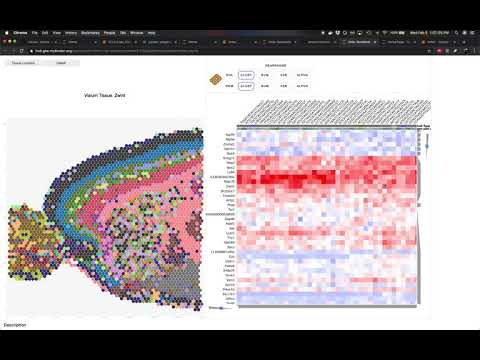

In [16]:
from IPython.display import YouTubeVideo

YouTubeVideo('eGDZA-xm_oc', width=800, height=500)